In [50]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 18, 12
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Get the Data

In [51]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [35]:
df[:5]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1024,1030,1030,1050,1065,1086,1169,1174,1162,1188
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,3210,3263,3322,3380,3443,3502,3544,3651,3670,3710
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,563,563,564,565,569,573,575,576,579,581
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,374,381,384,413,416,426,438,442,444,453
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,736,741,745,759,774,788,800,812,816,825


In [52]:
cols = df.columns.tolist()
cols[:13]

['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
 '1/22/20',
 '1/23/20']

In [53]:
cols_to_remove = ['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key']

In [54]:
df = df.drop(cols_to_remove, axis=1)
df[:5]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20
0,0,0,0,0,0,0,0,0,0,0,...,1024,1030,1030,1050,1065,1086,1169,1174,1162,1188
1,0,0,0,0,0,0,0,0,0,0,...,3210,3263,3322,3380,3443,3502,3544,3651,3670,3710
2,0,0,0,0,0,0,0,0,0,0,...,563,563,564,565,569,573,575,576,579,581
3,0,0,0,0,0,0,0,0,0,0,...,374,381,384,413,416,426,438,442,444,453
4,0,0,0,0,0,0,0,0,0,0,...,736,741,745,759,774,788,800,812,816,825


In [41]:
# Check for missing value
df.isnull().sum().sum()

0

In [55]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22    1
2020-01-23    1
2020-01-24    2
2020-01-25    2
2020-01-26    5
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

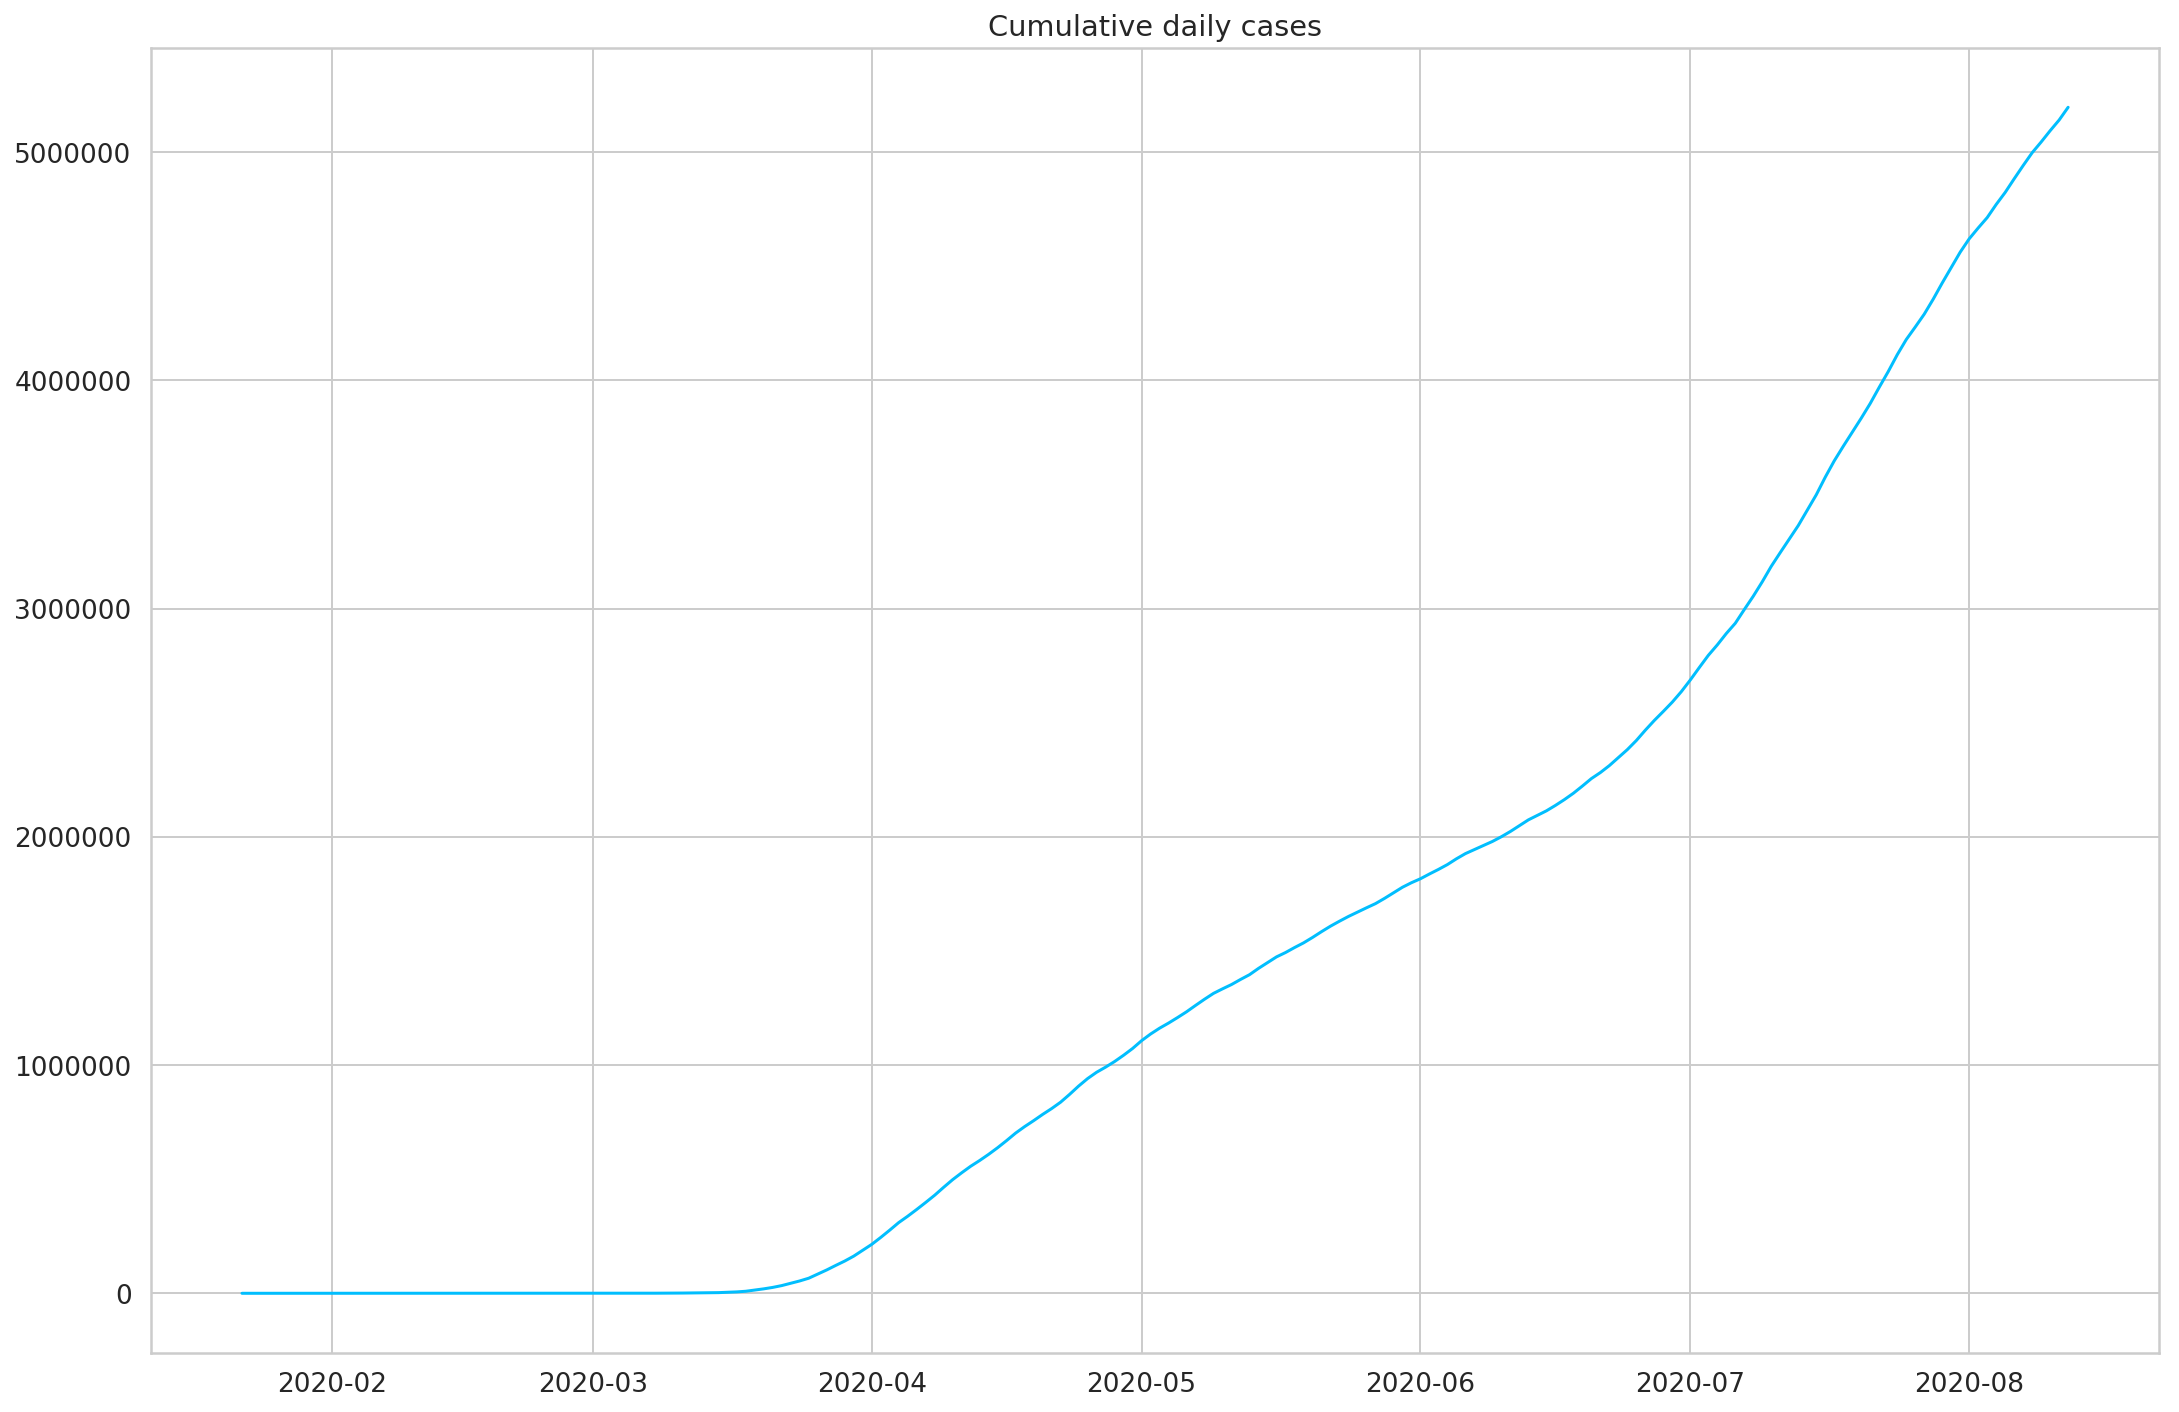

In [56]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

We’ll undo the accumulation by subtracting the current value from the previous. We’ll preserve the first value of the sequence:

In [57]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    1
2020-01-23    0
2020-01-24    1
2020-01-25    0
2020-01-26    3
dtype: int64

Text(0.5, 1.0, 'Daily cases')

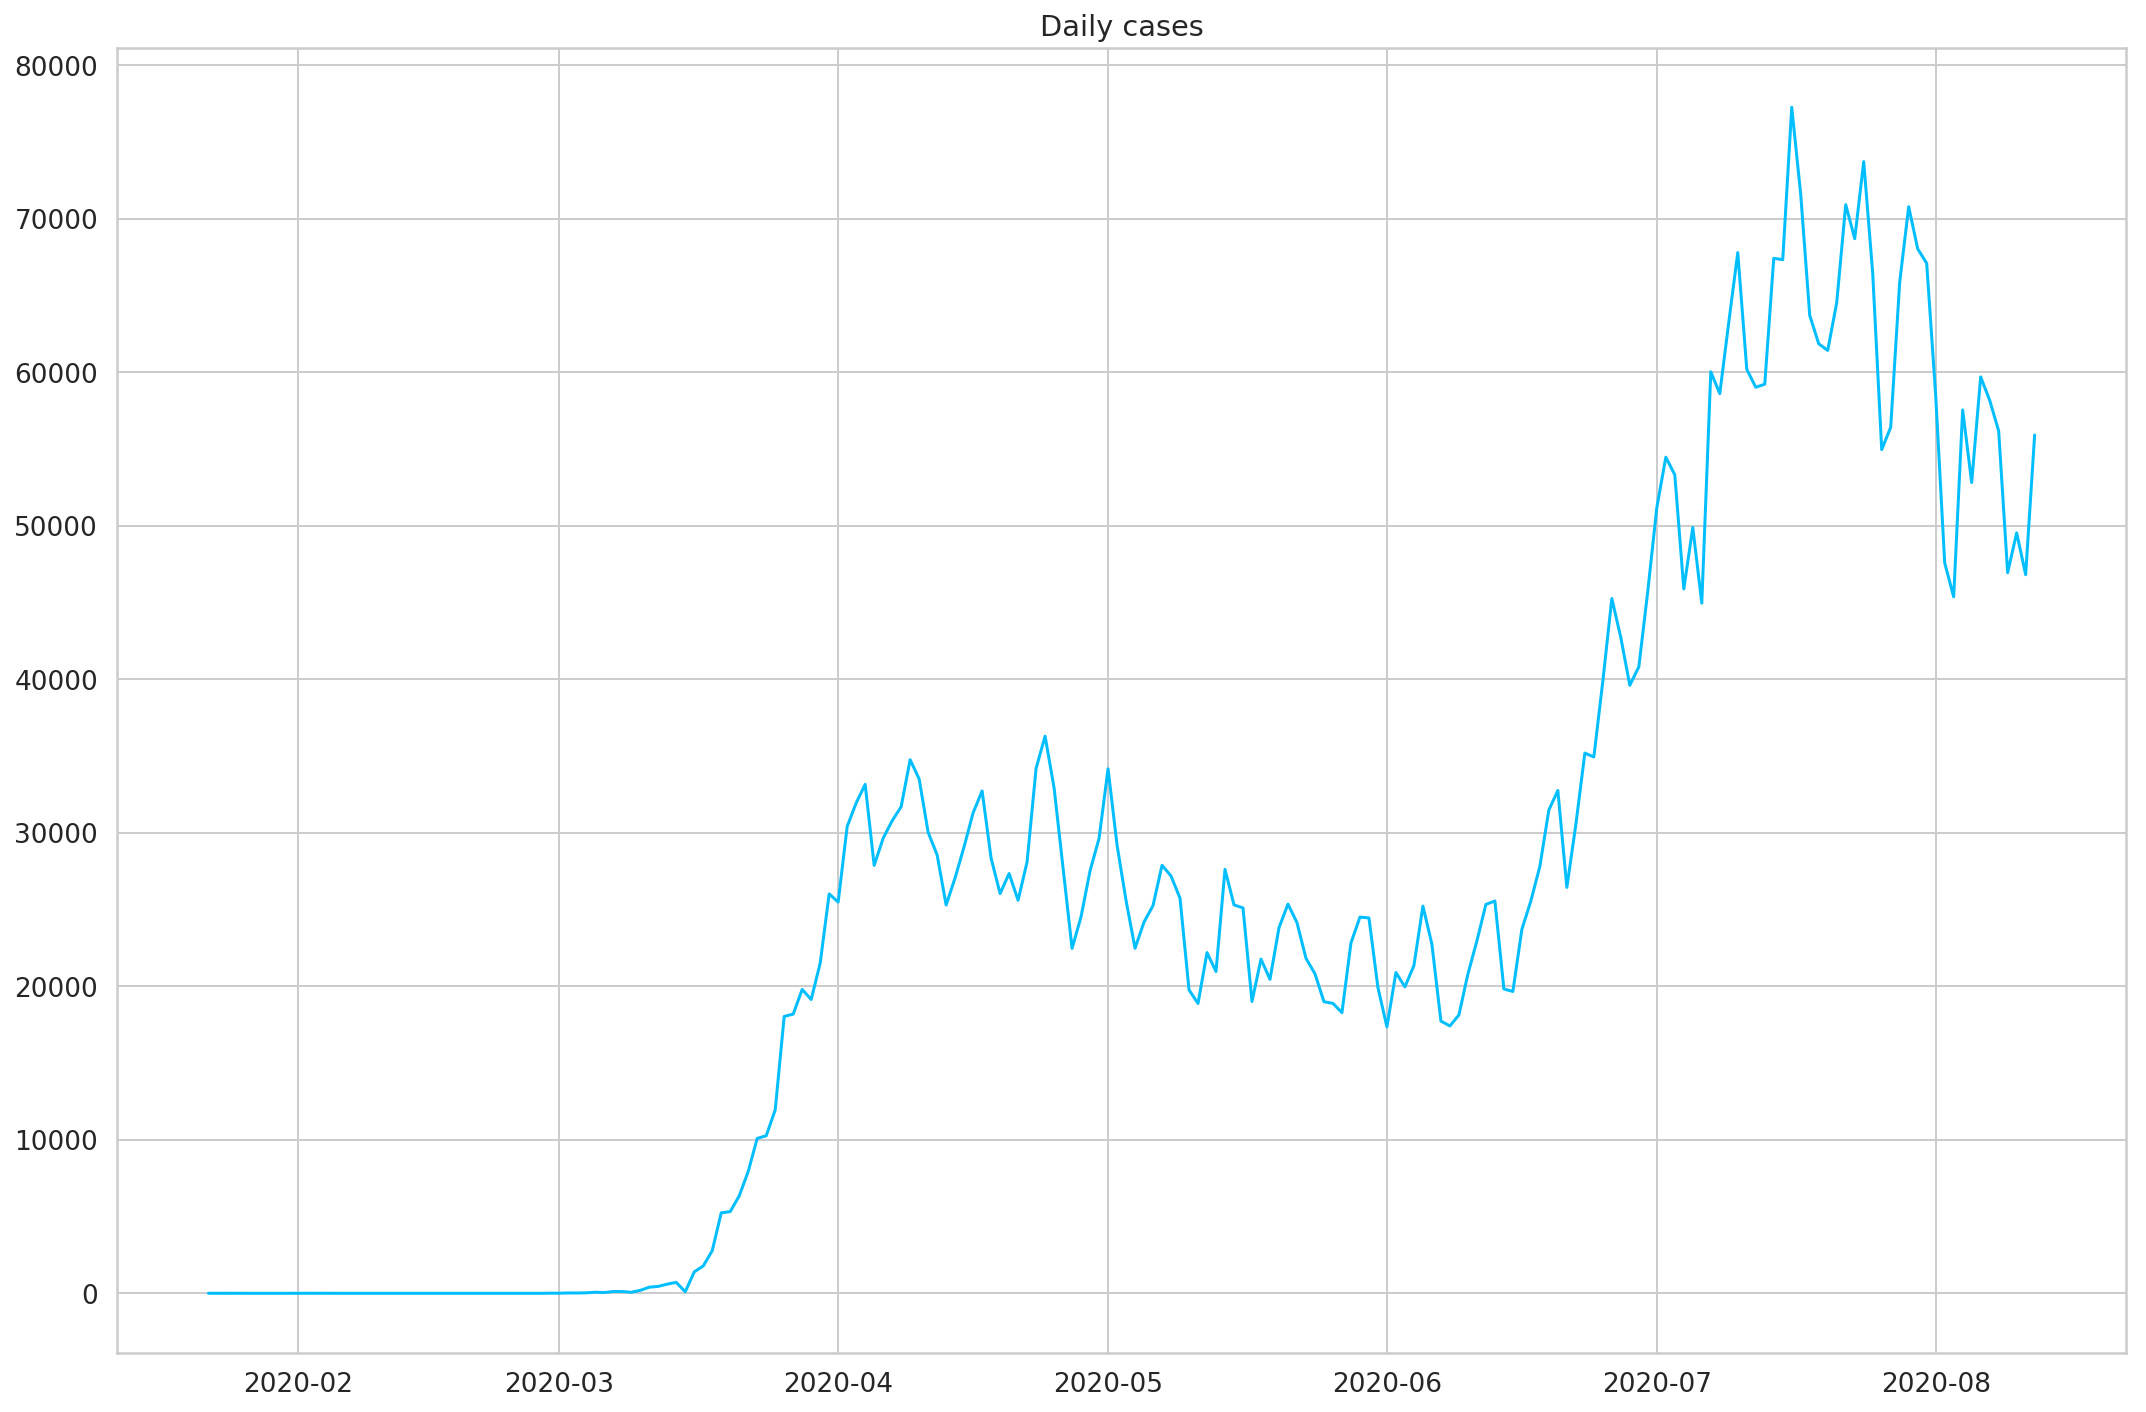

In [58]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [59]:
daily_cases.shape

(204,)

We'll work with 204 days

## Preprocessing

In [61]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

print(train_data.shape, test_data.shape)

(190,) (14,)


We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. 

In [62]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of daily cases. We’ll convert it into smaller ones:

In [64]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [65]:
seq_length = 10

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 10 data points of history and a label for the real value that our model needs to predict

In [66]:
X_train.shape

torch.Size([179, 10, 1])

There are 179 tensors of size 10 with 1 column

In [73]:
# Let's give a look to the first 2 tensors
X_train[:2]

tensor([[[1.2944e-05],
         [0.0000e+00],
         [1.2944e-05],
         [0.0000e+00],
         [3.8832e-05],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [2.5888e-05]],

        [[0.0000e+00],
         [1.2944e-05],
         [0.0000e+00],
         [3.8832e-05],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [2.5888e-05],
         [1.2944e-05]]])

In [74]:
y_train.shape

torch.Size([179, 1])

The shape of the label is a tensor with 179 elements

## Building a model

In [138]:
class COVID_forecast(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(COVID_forecast, self).__init__()
        
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, dropout=0.5)
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    # We’ll use a stateless LSTM, so we need to reset the state after each example   
    def reset_hidden_state(self):
        self.hidden = (
                        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
        
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred   

## Training

In [139]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 21
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
                test_hist[t] = test_loss.item()
                
        if t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
    
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    return model.eval(), train_hist, test_hist

In [140]:
model = COVID_forecast(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)

model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 30.02278709411621 test loss: 1.1464104652404785
Epoch 10 train loss: 11.863280296325684 test loss: 0.2541288137435913
Epoch 20 train loss: 10.587320327758789 test loss: 0.18834976851940155


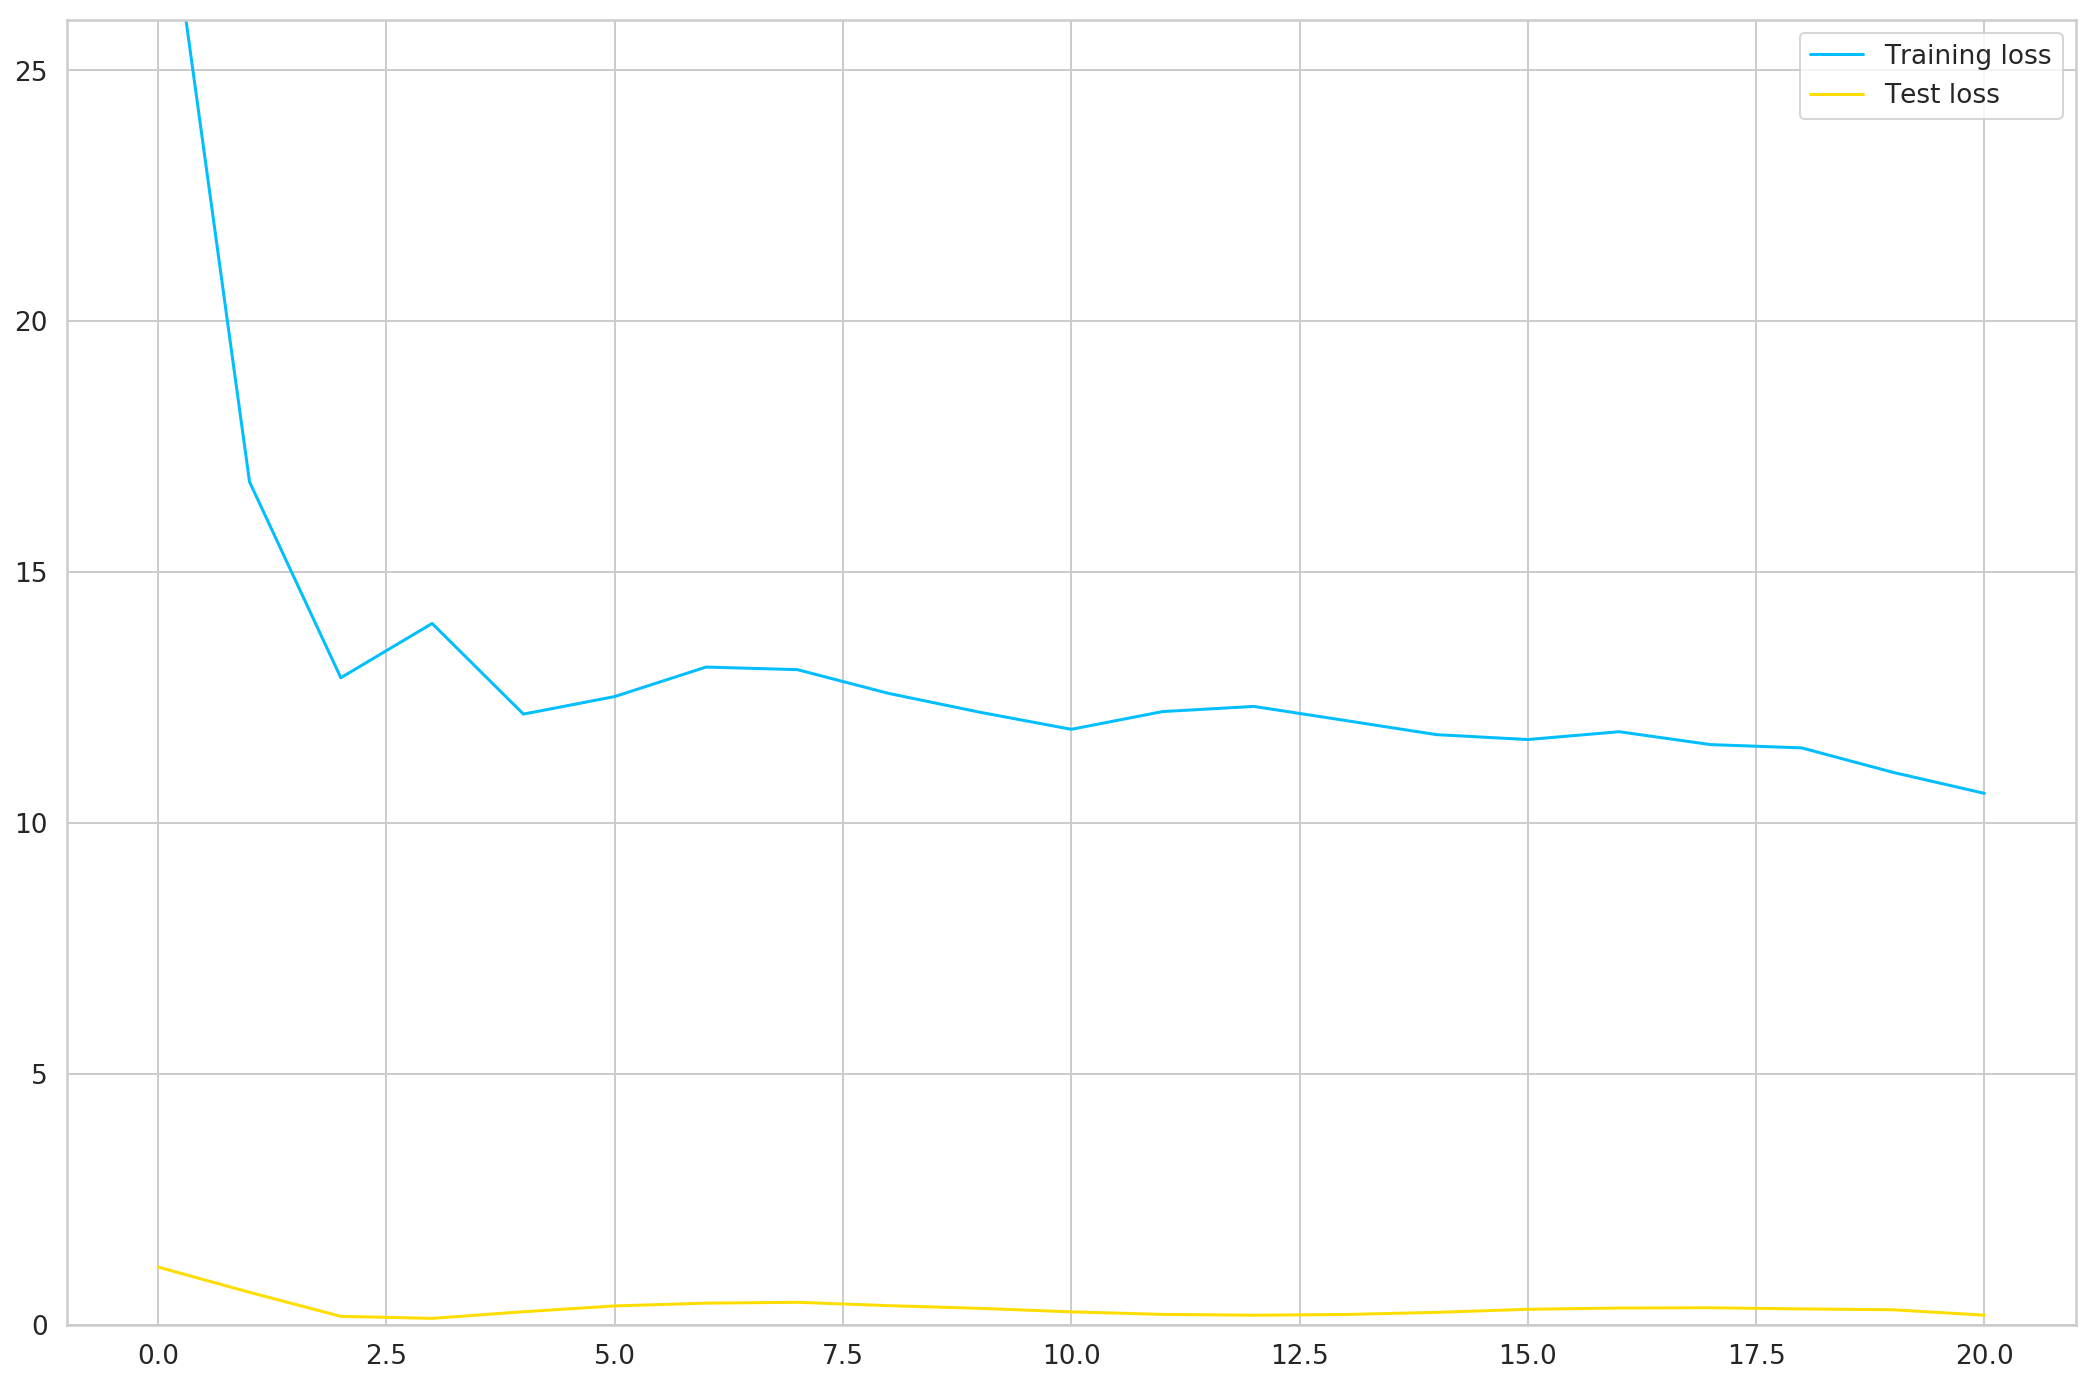

In [142]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 26))
plt.legend();

## Predicting daily cases

In [143]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [144]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()

predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

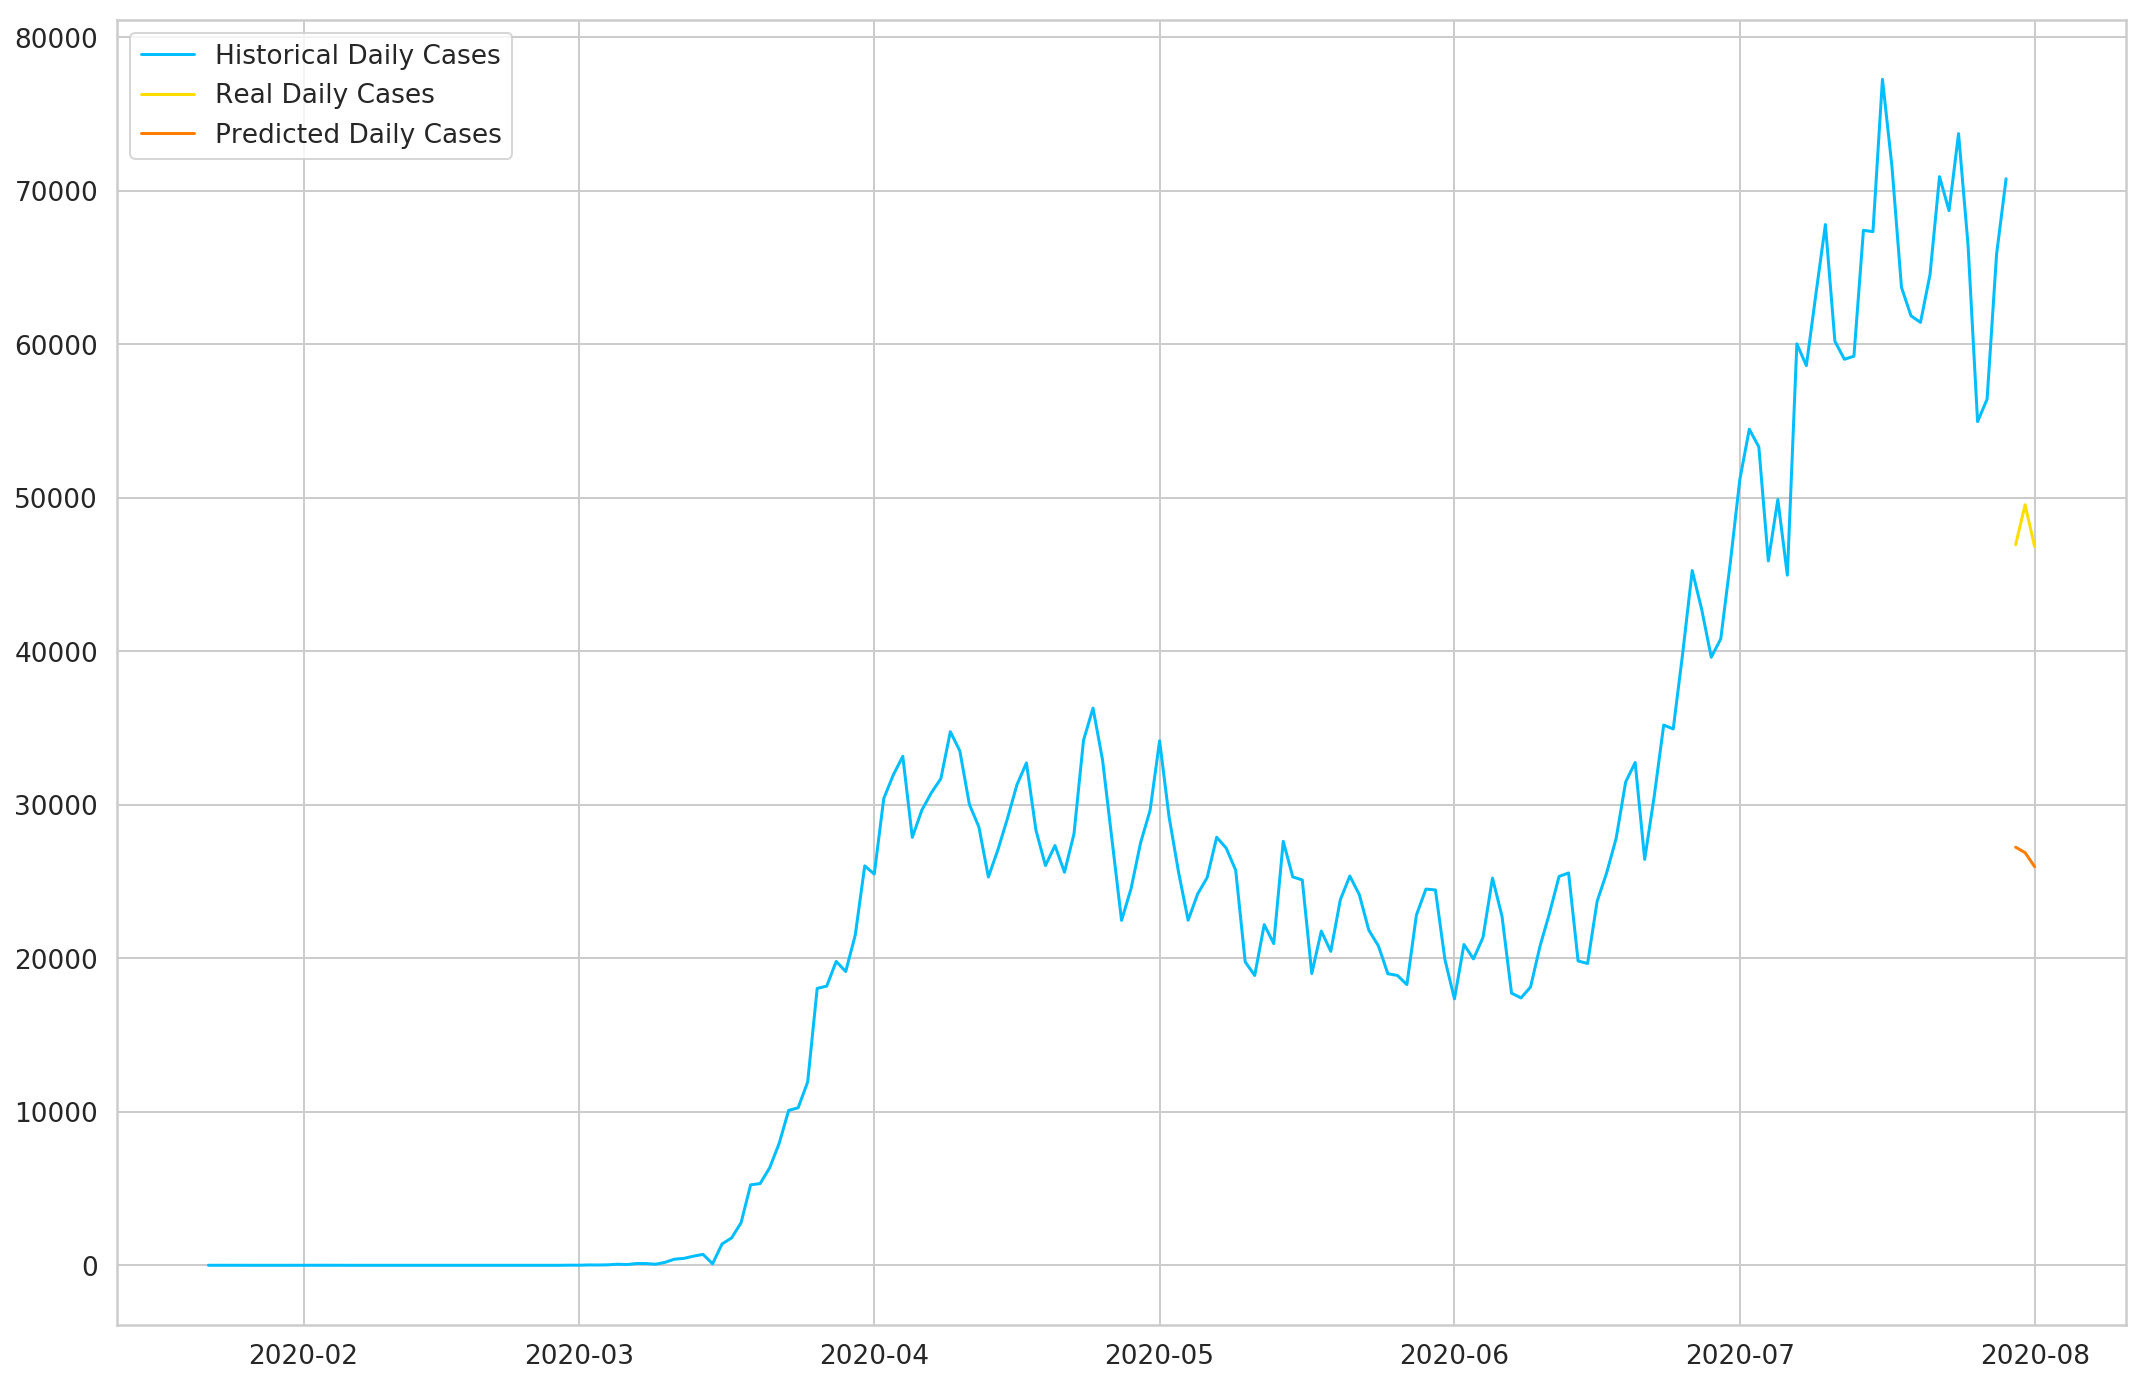

In [145]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend();